## Trabalho prático 2 - Implementação AdaBoost

*   Aluno: Diego Vinicius de Oliveira Silva
*   Matrícula: 2019054471

In [27]:
!pip install pandas scikit-learn numpy matplotlib

zsh:1: command not found: pip


In [28]:
import pandas as pd
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator
import matplotlib.pyplot as plt

## Importação dos dados

In [29]:
# Load data
dataset_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data'
tic_tac_toe_df = pd.read_csv(dataset_url, header=None)

## Limpeza dos dados

In [30]:
def symbol_to_numeric(symbol):
    symbol_map = {"x": 1, "positive": 1, "o": 0, "b": 2}
    return symbol_map.get(symbol, -1)

# Convert symbols to numeric values
numeric_dataset = tic_tac_toe_df.applymap(symbol_to_numeric)

## Dividir dados de teste e treino

In [31]:
# Split dataset into features and target
X = numeric_dataset.iloc[:, :9].values
y = numeric_dataset.iloc[:, 9].values

# Split data into training and testing sets
random_seed = 1
test_split_ratio = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split_ratio, random_state=random_seed)

## AdaBoost Classifier

In [32]:
class AdaBoostClassifier(BaseEstimator):
    def __init__(self, no_of_classifiers=100):
        self.no_of_classifiers = no_of_classifiers

    def get_params(self, deep=True):
        return {'no_of_classifiers': self.no_of_classifiers}

    def fit(self, X_train, y_train):
        self.errors = []
        self.weights = [1/len(X_train) for _ in range(len(X_train))]
        self.selected_stumps = []
        self.alphas = []
        decision_stumps = [[i, j, k] for i in range(9) for j in (0, 1, 2) for k in (1, -1)]
        decision_stumps.extend([[-1, '-', value] for value in (1, -1)])

        while self.no_of_classifiers > 0:
            best_error, best_stump = min(
                ((self.compute_error(stump, X_train, y_train), stump) for stump in decision_stumps), key=lambda x:x[0])
            self.errors.append(best_error) 

            alpha = 0.5 * np.log2((1.0 - best_error) / best_error)
            self.alphas.append(alpha)
            self.selected_stumps.append(best_stump)
            self.update_weights(alpha, best_stump, X_train, y_train)
            self.no_of_classifiers -= 1

    def game_classifier(self, decision_stump, game):
        if decision_stump[0] == -1:
            return decision_stump[2]
        elif game[decision_stump[0]] == decision_stump[1]:
            return decision_stump[2]
        else:
            return -decision_stump[2]

    def compute_error(self, decision_stump, X_train, y_train):
        error = sum(self.weights[i] for i in range(len(X_train)) if y_train[i] != self.game_classifier(decision_stump, X_train[i]))
        return error

    def update_weights(self, alpha, decision_stump, X_train, y_train):
        for i in range(len(X_train)):
            classification = self.game_classifier(decision_stump, X_train[i])
            self.weights[i] *= np.exp(-alpha * classification * y_train[i])
        total_weight = np.sum(self.weights)
        self.weights = [weight/total_weight for weight in self.weights]

    def predict(self, X_test):
        predictions = []
        for i in range(len(X_test)):
            score = sum(self.alphas[j] * self.game_classifier(self.selected_stumps[j], X_test[i]) for j in range(len(self.selected_stumps)))
            predictions.append(1 if score > 0 else -1)
        return predictions


## Realizando Busca em Grade para Otimizar o Número de Classificadores em um Modelo AdaBoost

In [33]:
# Define classifier counts to try
classifier_counts = np.arange(1, 151, 5)

# Define hyperparameters for grid search
hyperparameters = {'no_of_classifiers': classifier_counts}

# Create grid search object
grid_search = GridSearchCV(AdaBoostClassifier(), param_grid=hyperparameters, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'no_of_classifiers': array([  1,   6,  11,  16,  21,  26,  31,  36,  41,  46,  51,  56,  61,
        66,  71,  76,  81,  86,  91,  96, 101, 106, 111, 116, 121, 126,
       131, 136, 141, 146])},
             scoring='accuracy', verbose=1)

## Visualização dos Dados Obtidos pela Busca em Grade

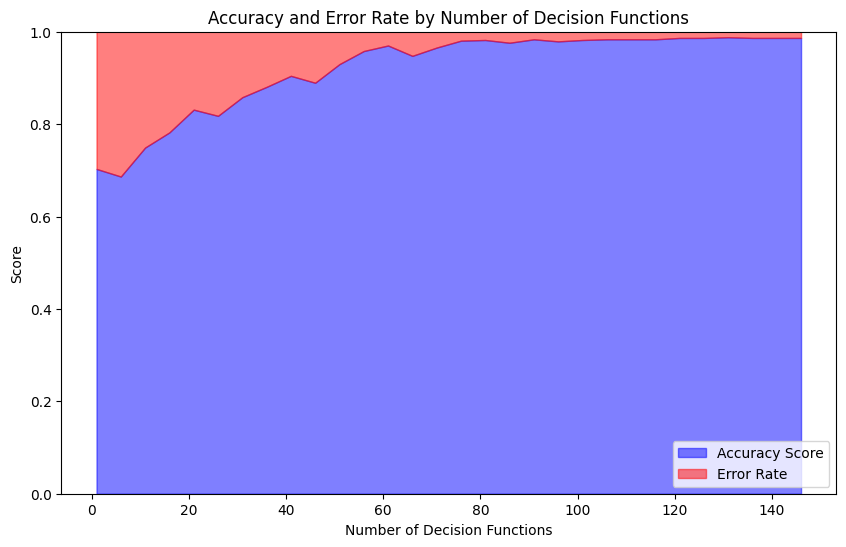

In [34]:
plt.figure(figsize=(10, 6))

# Calculate accuracy and error
accuracy = grid_search.cv_results_["mean_test_score"]
error = 1 - accuracy

# Plot accuracy and error as stacked areas
plt.fill_between(classifier_counts, 0, accuracy, color='b', alpha=0.5, label='Accuracy Score')
plt.fill_between(classifier_counts, accuracy, 1, color='r', alpha=0.5, label='Error Rate')

# Label plot
plt.xlabel('Number of Decision Functions')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.ylim(0, 1)

plt.title('Accuracy and Error Rate by Number of Decision Functions')
plt.show()

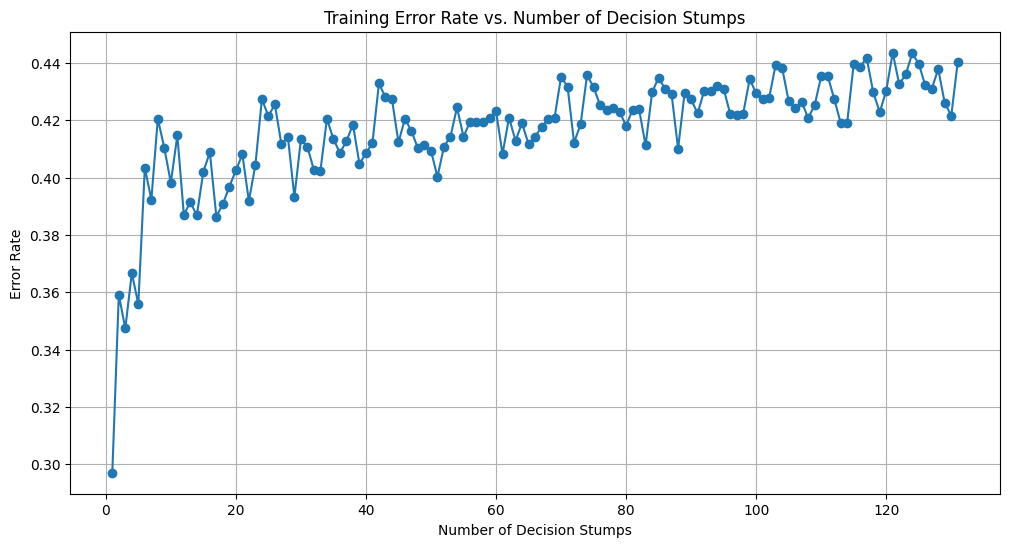

In [35]:
# Plot the error rates during training for the best model
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(grid_search.best_estimator_.errors) + 1), grid_search.best_estimator_.errors, marker='o')
plt.xlabel('Number of Decision Stumps')
plt.ylabel('Error Rate')
plt.title('Training Error Rate vs. Number of Decision Stumps')
plt.grid()
plt.show()